# Objectives
The objective of this project is to develop a real-time weather prediction model using a stream learning approach with the River library. Specifically, we aim to predict whether the temperature will increase or decrease in the next 6 hours based on hourly weather data collected over around one year (2024-2025) in A Coruña.

Weather prediction is a complex and dynamic task due to the continuous changes in atmospheric conditions. Using a stream learning approach allows the model to adapt to new patterns over time. Concept drift can occur between different seasons, where the changes in temperature follow different trends depending on the time of year.

Our main goal is to classify whether the temperature at a given time step will be higher or lower in 6 hours. This binary classification task will help in short-term weather forecasting, which is valuable for various sectors such as architecture or energy management.

The prediction is made using weather data from the current time step such as hummidity, pressure, or wind speed. Additionally, we also incorporate some features using the information from the 6 previous time steps. This features represent the average temperature over the current and these 6 previous time steps. This approach provides the model with some contextual information.

In [352]:
# Batch learning will fail if scikit is not downgraded for compatibility with river
%pip install scikit-learn==1.5.2


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Reading data and plot it.
import pandas as pd
import matplotlib.pyplot as plt

# Stream learning
from river import compose, preprocessing, linear_model, tree, metrics, evaluate, feature_extraction, \
    utils, stats, compat, drift, stream

# Batch learning 
from sklearn.pipeline import Pipeline as SklearnPipeline
from sklearn.preprocessing import StandardScaler as SklearnStandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import copy
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, roc_auc_score

# Load dataset

We used a dataset obtained from openweathermap.org,  specifically from their historical data repository. Thanks to the student plan offered by the platform, we obtained an access token, allowing us to make up to 3,000 API calls per minute to retrieve information from their historical database.

For this study, we selected A Coruña as the target location for our data requests. We were able to obtain hourly information from February 2024 to February 2025. Next, we will provide a more detailed explanation of this data.

In [59]:
# Read api request from a csv
converters = {
    # The first column is an index:
    "": lambda x: int(x) if x != "" else None,
    "dt": lambda x: int(x), # UNIX type timestamp with second precision, must be an int to feed it to the models
    "main.temp": lambda x: float(x),
    "main.feels_like": lambda x: float(x),
    "main.pressure": lambda x: int(x), # API gives int precision
    "main.humidity": lambda x: int(x), # API gives int precision
    "main.temp_min": lambda x: float(x),
    "main.temp_max": lambda x: float(x),
    "wind.speed": lambda x: float(x),
    "wind.deg": lambda x: int(x), # rotation degrees in int precision
    "wind.gust": lambda x: float(x) if x != "" else np.nan,
    "clouds.all": lambda x: int(x), # percentage of cloudiness in int precision
    "weather.id": lambda x: int(x), # the id is an integer
    "weather.main": lambda x: x,  # string conversion is implicit
    "weather.description": lambda x: x, # string
    "weather.icon": lambda x: x, # string
    "rain.1h": lambda x: float(x) if x != "" else np.nan # rain volume in mm
}

df = pd.read_csv("datasets/data.csv", converters=converters)
df.head()

,Unnamed: 0,dt,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,wind.gust,clouds.all,weather.id,weather.main,weather.description,weather.icon,rain.1h
0,0,1708617600,10.79,9.83,1010,73,9.14,11.61,7.72,290,14.92,75,803,Clouds,broken clouds,04d,NaN
1,1,1708621200,9.69,7.35,1010,81,8.58,11.40,4.63,290,NaN,75,803,Clouds,broken clouds,04d,NaN
2,2,1708624800,9.04,6.77,1010,84,8.03,10.44,4.12,260,NaN,75,803,Clouds,broken clouds,04d,NaN
3,3,1708628400,8.74,6.66,1010,82,7.50,10.50,3.60,250,NaN,75,300,Drizzle,light intensity drizzle,09n,NaN
4,4,1708632000,8.17,5.24,1010,84,6.92,9.38,5.14,250,NaN,75,300,Drizzle,light intensity drizzle,09n,NaN


**Feature description**

* dt: UNIX timestamp (starting at Thursday, 22 Feb 2024 17:0:0 GMT).
* main.temp: Current temperature in degrees Celsius.
* main.feels_like: This temperature parameter accounts for the human perception of weather.
* main.pressure: Atmospheric pressure on the sea level, hPa.
* main.humidity: Humidity, %.
* main.temp_min: Minimum temperature within a large city or a megalopolis.
* main.temp_max:  Maximum temperature within a large city or a megalopolis.
* wind.speed: Wind speed, m/s.
* wind.deg: Wind direction, degrees.
* wind.gust: Wind gust, m/s, NaN if not available.
* clouds.all: Cloudiness, %.
* weather.id: Weather condition id.
* weather.main: Group of weather parameters (Rain, Snow, Clouds etc.).
* weather.description: Weather condition within the group.
* weather.icon: Weather icon id.
* rain.1h: Rain volume for the last 1 hour, mm.

In [60]:
# Create the target feature and eliminate redundant features
df["temp_diff_6h"] = df["main.temp"].diff(periods=6)
df = df.dropna(subset=['temp_diff_6h'])
df["target"] = (df["temp_diff_6h"] > 0).astype(int)
# Not useful features
df = df.drop(["Unnamed: 0", "temp_diff_6h", "weather.description", "weather.icon"], axis = 1)
df.head(2)

,dt,main.temp,main.feels_like,main.pressure,main.humidity,main.temp_min,main.temp_max,wind.speed,wind.deg,wind.gust,clouds.all,weather.id,weather.main,rain.1h,target
6,1708639200,8.17,4.86,1010,86,6.92,9.88,6.17,250,NaN,20,801,Clouds,NaN,0
7,1708642800,7.83,4.56,1010,87,6.92,8.77,5.81,280,8.05,75,803,Clouds,NaN,0


# Descriptive analysis

**Numerical features**

Abnormal values are not observed in the numeric variables, as it can be seen in the table below

In [61]:
# Check numerical features and number of nulls
exclude_features = ["dt", "target", "weather.id"]
summary = df.drop(columns=exclude_features).describe().transpose()
summary['null_count'] = df.isnull().sum()

# Drop these two columns because they have too many nulls
df = df.drop(["wind.gust", "rain.1h"], axis = 1)
summary

,count,mean,std,min,25%,50%,75%,max,null_count
main.temp,8099.0,15.227539,4.342157,0.40,12.27,15.27,18.36,30.82,0
main.feels_like,8099.0,14.873391,4.945521,-2.62,11.76,15.08,18.39,34.06,0
main.pressure,8099.0,1016.263242,8.611026,976.00,1012.00,1017.00,1021.00,1038.00,0
main.humidity,8099.0,83.710705,10.291210,0.00,78.00,86.00,91.00,100.00,0
main.temp_min,8099.0,14.094718,4.353068,0.40,11.36,14.32,17.16,29.75,0
main.temp_max,8099.0,16.283323,4.419778,2.47,13.27,16.07,19.40,33.15,0
wind.speed,8099.0,3.731601,2.353587,0.00,2.06,3.13,4.92,18.78,0
wind.deg,8099.0,183.773182,110.833987,0.00,116.50,180.00,280.00,360.00,0
wind.gust,1278.0,8.254186,5.199148,0.45,3.58,7.60,12.35,25.21,6821
clouds.all,8099.0,41.230522,35.337897,0.00,0.00,40.00,75.00,100.00,0


**Categorical features**

- `weather.id` has a total of 16 unique values, being the most frequent values 800 which appears 2190 times in the dataset. 
- `weather.main` has a total of 7 categories, being the most frequent Clous which appears 4868 times in the dataset.
- The most frequent `target` is a decrease in the temperature (0) which appears 4570 times in the dataset.

In [7]:
# conversion to categories required for batch learning, but not for stream learning
df[['weather.id', "weather.main", "target"]] = df[['weather.id', "weather.main", "target"]].astype('category')
summary = df[['weather.id', "weather.main", 'target']].describe(include=['category']).transpose()
summary

,count,unique,top,freq
weather.id,8099,16,800,2190
weather.main,8099,7,Clouds,4868
target,8099,2,0,4570


**Class distribution**

The dataset used for this project is relatively balanced in terms of class distribution. However, the class "Decrease or maintain" has a slight higher frequency. Even though this is a small difference, it is a factor worth considering in the analysis and model development, as it could influence performance and the interpretation of results.

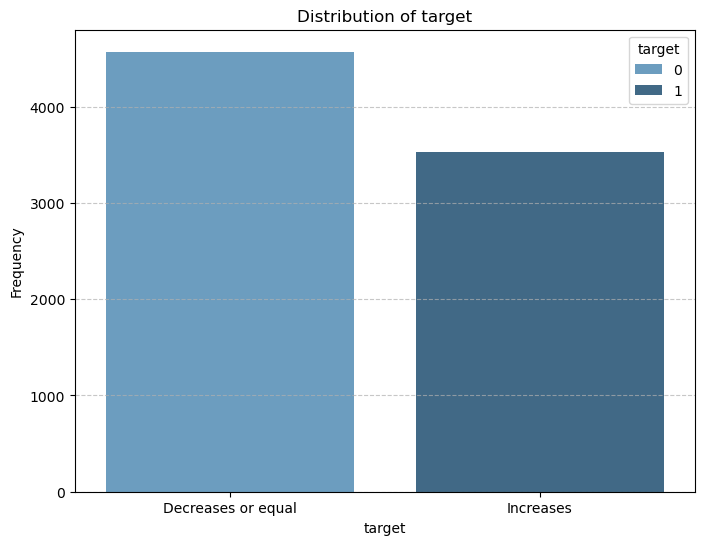

In [8]:
import seaborn as sns

# Class distribution of the dataset
plt.figure(figsize=(8, 6))
sns.countplot(x="target", hue="target", data=df, palette="Blues_d")
plt.ylabel("Frequency")
plt.title("Distribution of target")
plt.xticks(ticks=[0, 1], labels=['Decreases or equal', 'Increases'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

**Class distribution by time**

The class distribution remains consistent over time, with similar proportions observed across all months. The "Decrease or maintain" class still has a higher frequency, as previously noted. This suggest that this slight inbalance in the dataset is consistent over time and does not become more pronounced in specific months of the year.

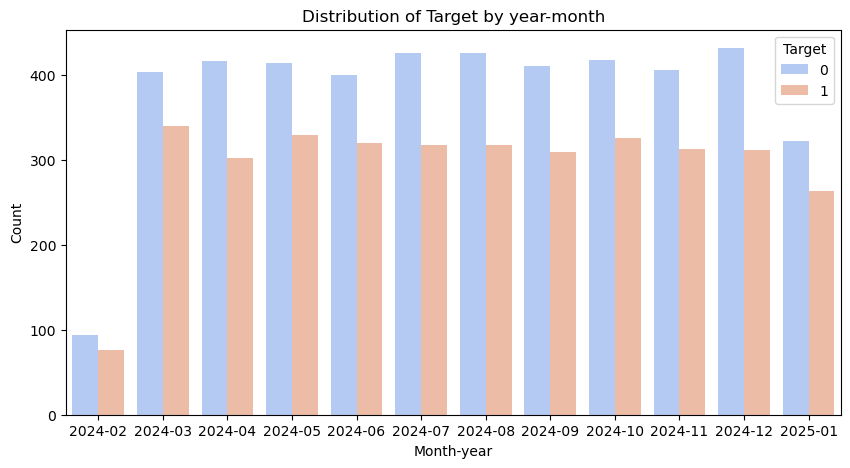

In [9]:
df_plot = copy.deepcopy(df)
df_plot["year_month"] = pd.to_datetime(df_plot["dt"], unit="s").dt.to_period("M")

# Class distribution by month year
plt.figure(figsize=(10, 5))
sns.countplot(data=df_plot, x="year_month", hue="target", palette="coolwarm")
plt.xlabel("Month-year")
plt.ylabel("Count")
plt.title("Distribution of Target by year-month")
plt.legend(title="Target", labels=["0", "1"])
plt.show()

# Train-test partition

In [10]:
# Last 1000 observations are reserved for the test set.
test_df = copy.deepcopy(df.tail(1000))
train_df = copy.deepcopy(df.iloc[:-1000])

X_train = train_df
y_train = X_train.pop('target')
X_test = test_df
y_test = X_test.pop('target')

The train partition used for this project is relatively balanced in terms of class distribution. 

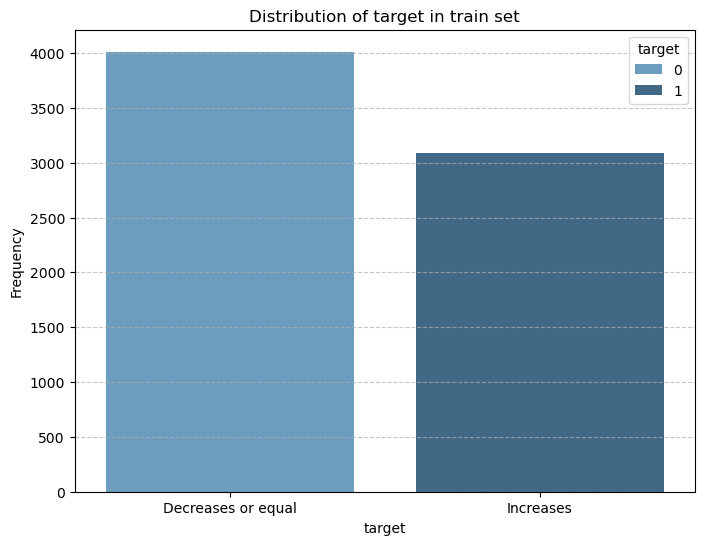

In [11]:
# Class distribution for train set
y_train_df = y_train.to_frame(name="target")
plt.figure(figsize=(8, 6))
sns.countplot(x="target", hue="target", data=y_train_df, palette="Blues_d")
plt.ylabel("Frequency")
plt.title("Distribution of target in train set")
plt.xticks(ticks=[0, 1], labels=['Decreases or equal', 'Increases'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

The test partition used for this project is relatively balanced in terms of class distribution. 

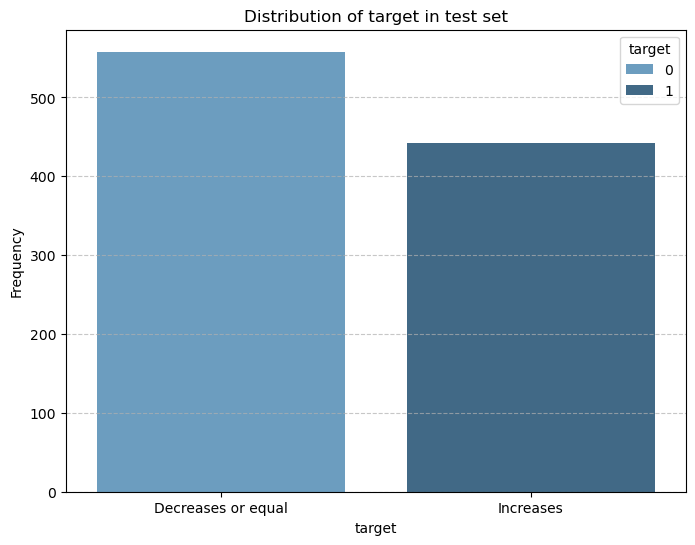

In [12]:
# Class distribution for test set.
y_test_df = y_test.to_frame(name="target")
plt.figure(figsize=(8, 6))
sns.countplot(x="target", hue="target", data=y_test_df, palette="Blues_d")
plt.ylabel("Frequency")
plt.title("Distribution of target in test set")
plt.xticks(ticks=[0, 1], labels=['Decreases or equal', 'Increases'])
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

# Batch learning results

Batch learning is not designed to deal with concept drift because it relies on training the model on the global dataset without a linear time perspective. 

This makes this approach not ideal for problems that need continuous adaptation, like the one we are trying to solve. We will see this refelected in the following results.

Moreover, AUC metric was considered in this project to evaluate the performance of the models. This metric was chosen because it is insentive to imbalanced datasets. AUC measures the area under the ROC curve. The Y axis of the ROC curve measures the proportion of actual positive instances that are correctly identified (recall), whereas the X axis measures the proportion of actual negative instances that are incorrectly classified (false positive rate). If we have a model that predicts all positive, it will have a good recall but a bad false positive rate and viceversa, which results in a low AUC.

The considered pipeline for this project perform the following steps:

1. Extracts the feature `month` from the date.
2. Performs OHE to categorical features `weather.main`, `weather.id`
3. Discards some not useful features.
4. Performs moving average transformation on some numerical features to provide some context.
5. Performs normalization or standarization depending on the features.

Some features like `dt`, `wind.deg`, `clouds.all`, `main.humidity` and `month` are bounded and are suitable for normalization. However, the rest of numerical features could have abnormal values, therefore, a standarization was preferred in those cases.

In [14]:
def create_features(modelo, wrapped=False, colIndex=None):
    """ 
    Creates a river pipeline with a specific preprocessing for given a model.

    Params:
        - modelo: River model to consider.
    """

    cols_rolling = ["main.temp", "main.feels_like", "main.pressure", "main.humidity", "wind.speed", "wind.deg"]
    to_discard = ['Unnamed: 0', 'wind.gust', 'weather.description', 'weather.icon', 'rain.1h', 'temp_diff_6h']
    to_categoric = ["weather.main", "weather.id"]

    # normalize attributes bounded by a fixed range
    to_normalize = ["dt", "wind.deg", "clouds.all", "main.humidity"]
    # for the newly created features that need to be normalized
    to_normalize_new = ["month"]

    # the old attribute will be discarded, the new one hot encoded attribute will remain
    to_discard += to_categoric
    dt = "dt"
    
    # when using the river to sklearn wrapper the names of attributes are lost and replaced by their ordered numerical index
    # by mapping using the column index dict, we solve this problem
    if wrapped:
        to_normalize_new = [] # without this line, batch training fails due to compatibility issues between sklearn and river
        cols_rolling = list(map(colIndex.get, cols_rolling))
        to_discard = list(map(colIndex.get, to_discard))
        to_categoric = list(map(colIndex.get, to_categoric))
        to_normalize = list(map(colIndex.get, to_normalize))
        dt = colIndex[dt]

    def get_date_features(x):
        # likewise we must translate the attribute name "dt" to its ordered index in case of wrapping
        date = x[dt]
            
        date = pd.to_datetime(date, unit = "s")
        # new feature is an integer
        month =  date.month
        
        x['month'] = month
        return x

 
    model = compose.FuncTransformer(get_date_features)

    # pass categorical attribute to an online one hot encoding
    model += (compose.Select(*to_categoric) | preprocessing.OneHotEncoder(drop_zeros=True))
        
    model |= compose.Discard(*to_discard)

    norm_list = to_normalize + to_normalize_new
        
    for col in cols_rolling:
        if col not in norm_list:
            model += feature_extraction.Agg(on = col, by=None, how=utils.Rolling(stats.Mean(), 6))

    # create a parallel pipeline to store aggregate the features that will be normalized
    transf_norm = compose.Select(*norm_list)
    for col in cols_rolling:
        if col in norm_list:
            transf_norm += feature_extraction.Agg(on = col, by=None, how=utils.Rolling(stats.Mean(), 6))
            
    model |= compose.TransformerUnion(
        transf_norm | preprocessing.Normalizer(order=2),
        compose.Discard(*norm_list) | preprocessing.StandardScaler()
    )
    model |= modelo

    return model

def get_sklearn_results(X_train, y_train, X_test, y_test, models, labels, colIndex):
    
    # Cross-validation procedure
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scorer = make_scorer(roc_auc_score)
    
    # List with test AUC metric of each model
    auc_list = []
    for i, model in enumerate(models):

        # Create river pipeline and convert to sklearn
        river_pipeline = create_features(model, wrapped=True, colIndex=colIndex)
        sk_pipeline = compat.convert_river_to_sklearn(river_pipeline)

        # Print cross-validation and test results for each model
        print(f"Results for {labels[i]}:")
        scores = cross_val_score(sk_pipeline, X_train, y_train, scoring=scorer, cv=cv)
        print(f'Cross-validation train ROC AUC: {scores.mean():.4f} (± {scores.std():.4f})')
        sk_pipeline.fit(X_train, y_train)
        y_pred = sk_pipeline.predict_proba(X_test)[:, 1]
        test_score = roc_auc_score(y_test, y_pred)
        auc_list.append(test_score)
        print(f'Test partition ROC AUC: {test_score:.4f} \n')
    
    return auc_list

colIndex = {v: k for k, v in enumerate(X_train.columns)}

labels_sk = ["LogisticRegression Default", "LogisticRegression l2=0.01", "LogisticRegression l2=0.5", "HoeffdingTree10", "HoeffdingTree25", 
          "HoeffdingTree50", "Perceptron Default", "Perceptron l2=0.01", "Perceptron clip_gradient=1.0", "Perceptron l2=0.5"]

models = [
    linear_model.LogisticRegression(),
    linear_model.LogisticRegression(l2=0.01),
    linear_model.LogisticRegression(l2=0.5),
    tree.HoeffdingTreeClassifier(grace_period=10),
    tree.HoeffdingTreeClassifier(grace_period=25),
    tree.HoeffdingTreeClassifier(grace_period=50),
    linear_model.Perceptron(),
    linear_model.Perceptron(l2=0.01),  # Perceptron with low L2 regularization
    linear_model.Perceptron(clip_gradient=1.0),  # Perceptron with limited gradient
    linear_model.Perceptron(l2=0.5)  # Perceptron with higher L2 regularization
]

sk_auc = get_sklearn_results(X_train, y_train, X_test, y_test, models, labels_sk, colIndex)

Results for LogisticRegression Default:
Cross-validation train ROC AUC: 0.6542 (± 0.0059)
Test partition ROC AUC: 0.6828 

Results for LogisticRegression l2=0.01:
Cross-validation train ROC AUC: 0.6563 (± 0.0071)
Test partition ROC AUC: 0.6903 

Results for LogisticRegression l2=0.5:
Cross-validation train ROC AUC: 0.6553 (± 0.0107)
Test partition ROC AUC: 0.7595 

Results for HoeffdingTree10:
Cross-validation train ROC AUC: 0.6629 (± 0.0401)
Test partition ROC AUC: 0.4799 

Results for HoeffdingTree25:
Cross-validation train ROC AUC: 0.6879 (± 0.0058)
Test partition ROC AUC: 0.5851 

Results for HoeffdingTree50:
Cross-validation train ROC AUC: 0.6870 (± 0.0219)
Test partition ROC AUC: 0.5926 

Results for Perceptron Default:
Cross-validation train ROC AUC: 0.4987 (± 0.0150)
Test partition ROC AUC: 0.2972 

Results for Perceptron l2=0.01:
Cross-validation train ROC AUC: 0.3963 (± 0.0432)
Test partition ROC AUC: 0.2769 

Results for Perceptron clip_gradient=1.0:
Cross-validation train R

Logistic Regression Default had the best test performance (0.6542) in the cross-validation and it will be the configuration that will be used and compared in stream learning. However, the test set indicates that the stronger model was LogisticRegression l2=0.5 with an AUC of 0.7595.

Hoeffding Tree models performed better than the other models in cross-validation, but their test performance varied significantly. As HoeffdingTree10 had the lowest grace period it was also the most liable to overfitting due to more decision splitting, which is reflected in its lower test score. HoeffdingTree25 and HoeffdingTree50 had the best balance and perform equally well. Finally, HoeffdingTree25 was chosen as the configuration to be compared in stream learning

Perceptron models performed poorly across the board, with ROC AUC scores below random chance (0.5) in cross-validation and even worse on the test partitions, indicating they are not suitable for this problem from a classical ML approach. 

# Stream learning

In [52]:
def stream_learning(X_train, y_train, X_test, y_test, modelo, drift_detect, model_name, is_bin_ddm=False):

    """
    Obtains the results in train and test partition using a specific river pipeline.
    Concept drift is considered using a drift detector, which resets the model when
    a drift is detected.

    Params:
        - X_train: Dataframe with input features in training set.
        - y_train: Dataframe with target in training set.
        - X_test: Dataframe with input features in test set.
        - y_test: Dataframe with target in test set.
        - model: River pipeline to consider.
        - drift_detector: River drift detector to consider.
        - model_name: Name of the model to consider.
    """

    # Lists to store concept drift indexes and accuracy over time
    drifts = []
    ROC_values = []

    # Intialize model, drift detector and metrics
    drift_detector = copy.deepcopy(drift_detect)
    model = copy.deepcopy(modelo)
    ROC = metrics.ROCAUC()
    report2 = metrics.ClassificationReport()

    counter = 0
    test_start = len(X_train)+1

    # Concatenate X_train and X_test to loop
    X = pd.concat([X_train, X_test], axis=0)
    y = pd.concat([y_train, y_test], axis=0)

    for xi, yi in stream.iter_pandas(X, y):

        if drift_detector.drift_detected:
            # Store position where drift was detected
            drifts.append(counter)
            # Reset model
            model = copy.deepcopy(modelo)
            # Reset drift detector
            drift_detector = copy.deepcopy(drift_detect)

        y_pred = model.predict_one(xi)
        model.learn_one(xi, yi)
        
        # Condition based on the type of drift detector
        if is_bin_ddm:
            drift_detector.update(1 if y_pred != yi else 0)
        else:
            drift_detector.update(yi)

        # If the prediction is not None, update metrics and report
        # each 100 instances.
        if y_pred != None:
            report2.update(yi, y_pred)
            ROC.update(yi, y_pred)
            # Save metric over time
            ROC_values.append(ROC.get())
        
        if counter == test_start:
            # Restart the metrics and report to evaluate test set correctly
            ROC = metrics.ROCAUC()
            report2 = metrics.ClassificationReport()

        counter += 1
            
    return ROC_values, drifts, report2

def get_models_results(X_train, y_train, X_test, y_test, models, drift_detector, is_bin_ddm=False):
    
    """
    Store the results for a model over train and test sets.

    Params:
    - X_train: Dataframe with input features in training set.
    - y_train: Dataframe with target in training set.
    - X_test: Dataframe with input features in test set.
    - y_test: Dataframe with target in test set.
    - model: River model to consider.
    - drift_detector: River drift detector to consider.
    """

    ROCs = []
    drifts = []
    reports = []

    for model in models:
        model_name = model.__class__.__name__
        model_instance = create_features(model)
        accuracies_model, drifts_model, report_model = stream_learning(X_train, y_train, X_test, y_test,
                                                                       modelo=model_instance, drift_detect=drift_detector,
                                                                       model_name=model_name, is_bin_ddm=is_bin_ddm)
        
        ROCs.append(accuracies_model)
        drifts.append(drifts_model)
        reports.append(report_model)

    # Optionally, you can zip the results and print them together
    print("\n")
    for i, model in enumerate(models):
        print(f"Results for {model.__class__.__name__}:")
        print("ROC-AUC:", float(round(ROCs[i][-1],4)))
        print("Drifts:", drifts[i])
        print("Report:", reports[i])
        print("\n")

    return ROCs, drifts, reports

def plot_roc(ROC_list, drifts, colors, labels, title, index_test):
    """
    Plots the results of the model with a detector, visualizing the metrics 
    and concept drift points over time.

    Params:
    - roc_list: List with values of a metric for each model.
    - drifts: List with the detected drifts for each model.
    """

    for i, ROC_values in enumerate(ROC_list):
        color = colors[i]
        label = labels[i]
        indices = np.arange(len(ROC_values))
        plt.plot(indices, ROC_values, label=label, color=color)

    for i, drift in enumerate(drifts):
        color = colors[i]
        label = labels[i]
        for value in drift:
            plt.scatter(value, ROC_list[i][value], color=color, marker='o', s=50) 

    plt.axvline(x=index_test, color="red", linestyle='-', label = "Test set start")

    plt.legend()
    plt.xlabel('Data instances processed')
    plt.ylabel('ROC-AUC')
    plt.title(title)
    plt.show()

# Concept drift detection



Results for LogisticRegression:
ROC-AUC: 0.7198
Drifts: [401, 5276, 5944, 6274, 6595, 6884, 7146, 7652, 8038]
Report:            Precision   Recall   F1       Support  
                                                  
       0      75.18%   75.18%   75.18%       556  
       1      68.78%   68.78%   68.78%       442  
                                                  
   Macro      71.98%   71.98%   71.98%            
   Micro      72.34%   72.34%   72.34%            
Weighted      72.34%   72.34%   72.34%            

                 72.34% accuracy                  


Results for HoeffdingTreeClassifier:
ROC-AUC: 0.6735
Drifts: [401, 5276, 5944, 6274, 6595, 6884, 7146, 7652, 8038]
Report:            Precision   Recall   F1       Support  
                                                  
       0      71.40%   69.86%   70.62%       554  
       1      63.13%   64.85%   63.98%       441  
                                                  
   Macro      67.27%   67.35%   67.30%  

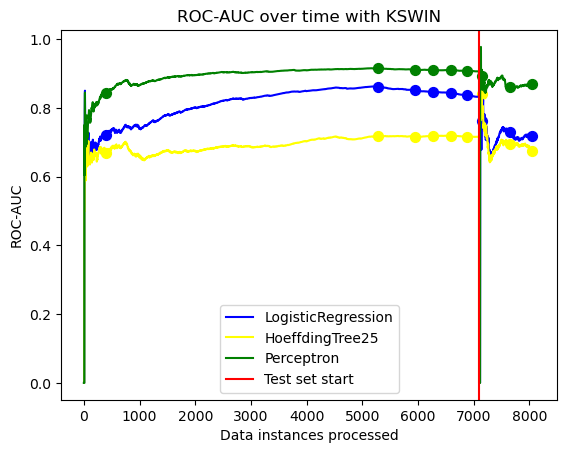

In [53]:
# Define parameters of the experiment.
models = [linear_model.LogisticRegression(),
          tree.HoeffdingTreeClassifier(grace_period=25),
          linear_model.Perceptron()]
colors = ["blue", "yellow", "green"]
labels = ["LogisticRegression", "HoeffdingTree25", "Perceptron"]

# Plot results
ROC, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector=drift.KSWIN(alpha=0.001, seed=42))
plot_roc(ROC, drifts, colors, labels, title = "ROC-AUC over time with KSWIN", index_test = len(X_train)+1)



Results for LogisticRegression:
ROC-AUC: 0.8652
Drifts: []
Report:            Precision   Recall   F1       Support  
                                                  
       0      85.79%   92.27%   88.91%       556  
       1      89.25%   80.77%   84.80%       442  
                                                  
   Macro      87.52%   86.52%   86.85%            
   Micro      87.17%   87.17%   87.17%            
Weighted      87.32%   87.17%   87.09%            

                 87.17% accuracy                  


Results for HoeffdingTreeClassifier:
ROC-AUC: 0.6381
Drifts: []
Report:            Precision   Recall   F1       Support  
                                                  
       0      68.06%   67.45%   67.75%       556  
       1      59.51%   60.18%   59.84%       442  
                                                  
   Macro      63.78%   63.81%   63.80%            
   Micro      64.23%   64.23%   64.23%            
Weighted      64.27%   64.23%   64.25%  

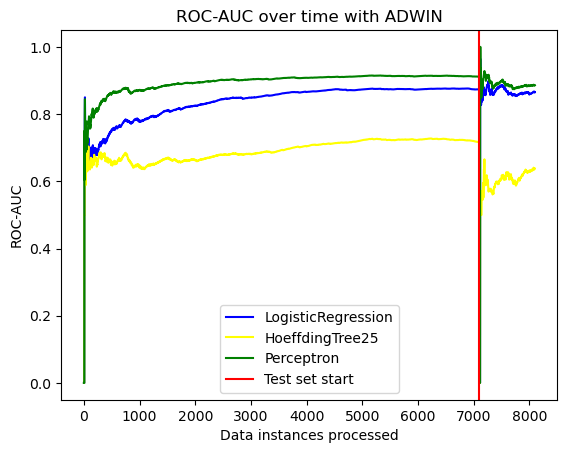

In [54]:
# Plot results
ROC, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector=drift.ADWIN())
plot_roc(ROC, drifts, colors, labels, title = "ROC-AUC over time with ADWIN", index_test = len(X_train)+1)

KSWIN (Kolmogorov-Smirnov Windowing) improves slightly the Hoeffding Tree classifier when compared to ADWIN as it detects changes in the data distribution by comparing the current window with a historical window. By detecting these changes and resetting the model, KSWIN allows the HT to adapt more quickly to new conditions, improving its performance. This detector is also more sensitive than ADWIN and thus liable to detect false positive, which have impacted the logistic regression model's performance.

ADWIN (Adaptive Windowing) fails to detect any drift. This may be because it is designed to detect changes in the mean of the data distribution while KSWIN can detect changes in the standard deviation of a distribution as well. If the changes in the data are more gradual or do not significantly affect the mean (but do affect variance or other characteristics), ADWIN does not detect drift. This means that the model continues learning without being reset, which can be beneficial if the data does not change drastically, but detrimental if the model needs to adapt. The more flexible model like logistic regression and the perceptron work well without being reset, but the Hoeffding Tree struggles substantially more than with other drift detectors.

### Binary drift detectors



Results for LogisticRegression:
ROC-AUC: 0.8636
Drifts: [99, 198, 410, 538, 654, 778]
Report:            Precision   Recall   F1       Support  
                                                  
       0      85.86%   91.73%   88.70%       556  
       1      88.61%   81.00%   84.63%       442  
                                                  
   Macro      87.24%   86.36%   86.66%            
   Micro      86.97%   86.97%   86.97%            
Weighted      87.08%   86.97%   86.90%            

                 86.97% accuracy                  


Results for HoeffdingTreeClassifier:
ROC-AUC: 0.7072
Drifts: [90, 242, 331, 433, 551, 660, 783, 993, 1122, 1237, 1654, 1847, 1960, 2066, 2205, 2327, 2510, 2591, 2723, 2820, 3309, 3420]
Report:            Precision   Recall   F1       Support  
                                                  
       0      76.92%   66.55%   71.36%       556  
       1      64.02%   74.89%   69.03%       442  
                                             

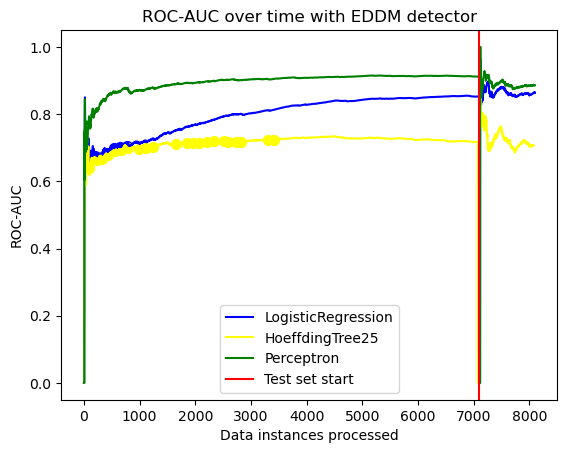

In [55]:
# Plot results
ROC, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector=drift.binary.EDDM(), is_bin_ddm=True)
plot_roc(ROC, drifts, colors, labels, title = "ROC-AUC over time with EDDM detector", index_test = len(X_train)+1)



Results for LogisticRegression:
ROC-AUC: 0.8533
Drifts: [986, 1531, 1733, 3338]
Report:            Precision   Recall   F1       Support  
                                                  
       0      85.35%   90.11%   87.66%       556  
       1      86.62%   80.54%   83.47%       442  
                                                  
   Macro      85.98%   85.33%   85.57%            
   Micro      85.87%   85.87%   85.87%            
Weighted      85.91%   85.87%   85.81%            

                 85.87% accuracy                  


Results for HoeffdingTreeClassifier:
ROC-AUC: 0.6948
Drifts: [318, 784, 989, 1531, 2747, 2908, 3338, 4553, 4974, 5335, 5791, 5931, 6510, 6673, 6896, 7278, 7539, 7678, 7971]
Report:            Precision   Recall   F1       Support  
                                                  
       0      74.27%   68.90%   71.48%       553  
       1      64.24%   70.07%   67.03%       441  
                                                  
   Macro    

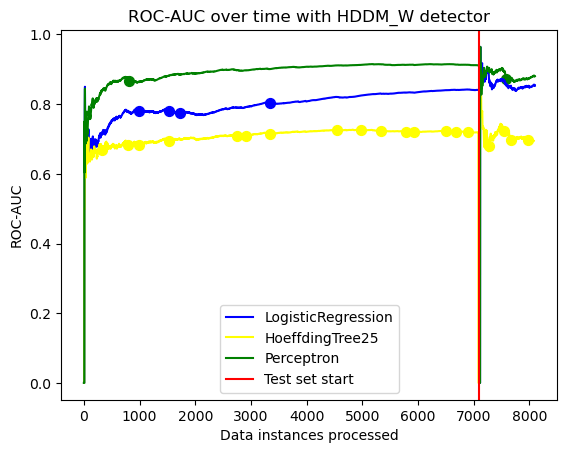

In [56]:
# Plot results
ROC, drifts, reports = get_models_results(X_train, y_train, X_test, y_test, models, drift_detector=drift.binary.HDDM_W(), is_bin_ddm=True)
plot_roc(ROC, drifts, colors, labels, title = "ROC-AUC over time with HDDM_W detector", index_test = len(X_train)+1)

EDDM (Early Drift Detection Method) slightly improves the Hoeffding Trees since it is more sensitive to gradual changes in the error rate. Therefore, when a significant drift occurs, EDDM enables the model to detect the change and adjust more quickly.

HDDM_W (Hoeffding Drift Detection Method – Weighted) improves Hoeffding Tree performance when compared to KSWIN and ADWIN (with the latter detecting no concept drifts). This method is based on the distribution of recent errors, giving more weight to recent observations, which seems to be a more effective method than the window based ones even if EDDM performs a bit better.

The graphs for KSWIN and HDDM_W show higher concentration of concept drift detection to the sides, while they detect fewer drifts in the middle of the graph. This is likely because the middle months have more stable and predictable weather conditions, making sudden distribution shifts less frequent.

# Approach comparison

As we can see, the stream approach gives the best results in all the models. This is because batch learning is incapable of adapting to new changes in the data, which are frequent in real time temperature prediction. It is specially notable how the perceptron improves with respect to the batch approach with an increase above 40% in AUC. 

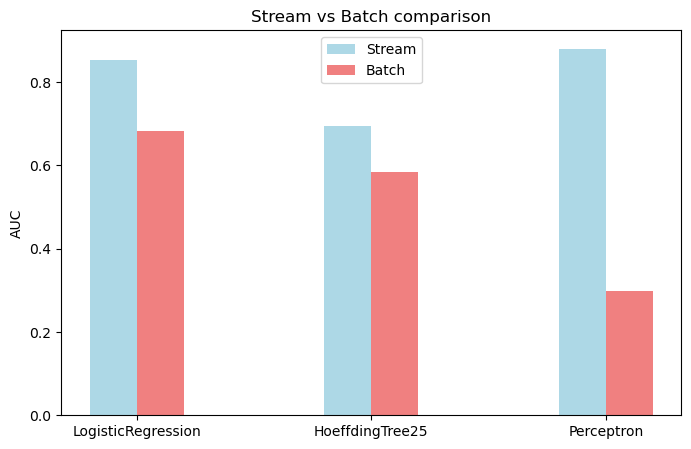

In [57]:
def compare_models_plot(auc_batch, auc_stream, models):
    x = np.arange(len(models))
    _, ax = plt.subplots(figsize=(8, 5))
    ax.bar(x - 0.10, auc_stream, 0.20, label="Stream", color="lightblue")
    ax.bar(x + 0.10, auc_batch, 0.20, label="Batch", color="lightcoral")
    ax.set_ylabel("AUC")
    ax.set_title("Stream vs Batch comparison")
    ax.set_xticks(x)
    ax.set_xticklabels(models)
    ax.legend()
    plt.show()


auc_batch = [sk_auc[0], sk_auc[4], sk_auc[6]]
auc_stream = [roc[-1] for roc in ROC]
models = ["LogisticRegression", "HoeffdingTree25", "Perceptron"]
compare_models_plot(auc_batch, auc_stream, models)